In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from konlpy.utils import partition
import re
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import CategoricalNB
from keras.models import Sequential 
from keras.layers import Dense
from keras import optimizers
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 가져오기

In [5]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36121 entries, 0 to 36120
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  36121 non-null  object
 1   label     36121 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 564.5+ KB


In [ ]:
with open("data/khaiii_train.pkl","rb") as fr:
    khaiii_train=pickle.load(fr)
with open("data/khaiii_test.pkl","rb") as fr:
    khaiii_test=pickle.load(fr)

train['khaiii']=khaiii_train
test['khaiii']=khaiii_test

In [ ]:
with open("data/mecab_train.pkl","rb") as fr:
    mecab_train=pickle.load(fr)
with open("data/mecab_test.pkl","rb") as fr:
    mecab_test=pickle.load(fr)

train['mecab']=mecab_train
test['mecab']=mecab_test

In [ ]:
with open("data/okt_train.pkl","rb") as fr:
    okt_train=pickle.load(fr)
with open("data/okt_test.pkl","rb") as fr:
    okt_test=pickle.load(fr)

train['okt']=okt_train
test['okt']=okt_test

In [ ]:
# train=train[:int(train.shape[0]/3)]
# test=test[:int(test.shape[0]/3)]

# stopwords

In [ ]:
stopwords=['아','휴','아이구','아이쿠','아이고','어','나','우리','저희','따라','의해','을','를','에','의','가','으로','로','에게','뿐이다','의거하여','근거하여','입각하여','기준으로',
'예하면','예를 들면','예를 들자면','저','소인','소생','저희','지말고','하지마','하지마라','다른','물론','또한','그리고','비길수 없다','해서는 안된다','뿐만 아니라','만이 아니다',
'만은 아니다','막론하고','관계없이','그치지 않다','그러나','그런데','하지만','든간에','논하지 않다','따지지 않다','설사','비록','더라도','아니면','만' '못하다','하는 편이 낫다',
'불문하고','향하여','향해서','향하다','쪽으로','틈타','이용하여','타다','오르다','제외하고','이 외에','이 밖에','하여야','비로소','한다면' '몰라도','외에도','이곳','여기','부터',
'기점으로,따라서','할 생각이다','하려고하다','이리하여','그리하여','그렇게' '함으로써','하지만','일때','할때','앞에서','중에서','보는데서','으로써','로써','까지','해야한다',
'일것이다','반드시','할줄알다','할수있다','할수있어','임에 틀림없다','한다면','등','등등','제','겨우','단지','다만','할뿐','딩동','댕그','대해서','대하여','대하면','훨씬','얼마나',
'얼마만큼','얼마큼','남짓','여','얼마간','약간','다소','좀','조금','다수','몇','얼마','지만','하물며','또한','그러나','그렇지만','하지만','이외에도','대해 말하자면','뿐이다','다음에',
'반대로','반대로 말하자면','이와 반대로','바꾸어서 말하면','바꾸어서 한다면','만약','그렇지않으면','까악','툭','딱','삐걱거리다','보드득','비걱거리다','꽈당','응당','해야한다',
'에 가서','각','각각','여러분','각종','각자','제각기','하도록하다','와','과','그러므로','그래서','고로','한 까닭에','하기 때문에','거니와','이지만','대하여','관하여','관한','과연',
'실로','아니나다를가','생각한대로','진짜로','한적이있다','하곤하였다','하','하하','허허','아하','거바','와','오','왜','어째서','무엇때문에','어찌','하겠는가','무슨','어디','어느곳',
'더군다나','하물며','더욱이는','어느때','언제','야','이봐','어이','여보시오','흐흐','흥','휴','헉헉','헐떡헐떡','영차','여차','어기여차','끙끙','아야','앗','아야','콸콸','졸졸','좍좍','뚝뚝',
'주룩주룩','솨','우르르','그래도','또','그리고','바꾸어말하면','바꾸어말하자면','혹은','혹시','답다','및','그에 따르는','때가 되어','즉','지든지','설령','가령','하더라도','할지라도',
'일지라도','지든지','몇','거의,하마터면','인젠','이젠','된바에야','된이상','만큼','어찌됏든','그위에','게다가','점에서 보아','비추어 보아','고려하면','하게될것이다','일것이다',
'비교적','좀','보다더','비하면','시키다','하게하다','할만하다','의해서','연이서','이어서','잇따라','뒤따라','뒤이어','결국','의지하여','기대여','통하여','자마자','더욱더','불구하고',
'얼마든지','마음대로','주저하지 않고','곧','즉시','바로','당장','하자마자','밖에' '안된다','하면된다','그래','그렇지','요컨대','다시 말하자면','바꿔 말하면','즉','구체적으로',
'말하자면','시작하여','시초에','이상','허','헉','허걱','바와같이','해도좋다','해도된다','게다가','더구나','하물며','와르르','팍','퍽','펄렁','동안','이래','하고있었다','이었다','에서',
'로부터','까지','예하면','했어요','해요','함께','같이','더불어','마저','마저도','양자','모두','습니다','가까스로','하려고하다','즈음하여','다른','다른 방면으로','해봐요','습니까',
'했어요','말할것도 없고','무릎쓰고','개의치않고','하는것만 못하다','하는것이 낫다','매','매번','들','모','어느것','어느','로써','갖고말하자면','어디','어느쪽','어느것','어느해',
'어느 년도','라' '해도','언젠가','어떤것','어느것','저기','저쪽','저것','그때','그럼','그러면','요만한걸','그래','그때','저것만큼','그저','이르기까지','할 줄 안다','할 힘이' '있다',
'너','너희','당신','어찌','설마','차라리','할지언정','할지라도','할망정','할지언정','구토하다','게우다','토하다','메쓰겁다','옆사람','퉤','쳇','의거하여','근거하여','의해','따라',
'힘입어','그','다음','버금','두번째로','기타','첫번째로','나머지는','그중에서','견지에서','형식으로 쓰여','입장에서','위해서','단지','의해되다','하도록시키다','뿐만아니라',
'반대로','전후','전자','앞의것','잠시','잠깐','하면서','그렇지만','다음에','그러한즉','그런즉','남들','아무거나','어찌하든지','같다','비슷하다','예컨대','이럴정도로','어떻게',
'만약','만일','위에서' '서술한바와같이','인 듯하다','하지 않는다면','만약에','무엇','무슨','어느','어떤','아래윗','조차','한데','그럼에도 불구하고','여전히','심지어','까지도',
'조차도','하지 않도록','않기 위하여','때','시각','무렵','시간','동안','어때','어떠한','하여금','네','예','우선','누구','누가' '알겠는가','아무도','줄은모른다','줄은 몰랏다','하는 김에',
'겸사겸사','하는바','그런 까닭에','한 이유는','그러니','그러니까','때문에','그','너희','그들','너희들','타인','것','것들','너','위하여','공동으로','동시에','하기 위하여','어찌하여',
'무엇때문에','붕붕','윙윙','나','우리','엉엉','휘익','윙윙','오호','아하','어쨋든','만 못하다','하기보다는','차라리,하는 편이 낫다','흐흐','놀라다','상대적으로 말하자면','마치',
'아니라면','쉿','그렇지 않으면','그렇지' '않다면','안 그러면','아니었다면','하든지','아니면','이라면','좋아','알았어','하는것도','그만이다','어쩔수 없다','하나','일','일반적으로',
'일단','한켠으로는','오자마자','이렇게되면','이와같다면','전부','한마디','한항목','근거로','하기에','아울러','하지 않도록','않기 위해서','이르기까지','이 되다','로 인하여',
'까닭으로','이유만으로','이로 인하여','그래서','이 때문에','그러므로','그런 까닭에','알 수 있다','결론을 낼 수 있다','으로 인하여','있다','어떤것','관계가 있다','관련이 있다',
'연관되다','어떤것들','에 대해','이리하여','그리하여','여부','하기보다는','하느니','하면 할수록','운운','이러이러하다','하구나','하도다','다시말하면','다음으로','에 있다',
'에 달려 있다','우리','우리들','오히려','하기는한데','어떻게','어떻해','어찌됏어','어때','어째서','본대로','자','이','이쪽','여기','이것','이번','이렇게말하자면','이런','이러한',
'이와 같은','요만큼','요만한 것','얼마 안 되는 것','이만큼','이 정도의','이렇게 많은 것','이와 같다','이때','이렇구나','것과 같이','끼익','삐걱,따위','와 같은 사람들',
'부류의 사람들','왜냐하면','중의하나','오직','오로지','에 한하다','하기만 하면','도착하다','까지 미치다','도달하다','정도에 이르다','할 지경이다','결과에 이르다','관해서는',
'여러분','하고 있다','한 후','혼자','자기','자기집','자신','우에' '종합한것과같이','총적으로' '보면','총적으로' '말하면','총적으로','대로 하다','으로서','참','그만이다','할 따름이다','쿵',
'탕탕','쾅쾅','둥둥','봐','봐라','아이야','아니','와아','응','아이','참나','년','월','일','령','영','일','이','삼','사','오','육','륙','칠','팔','구','이천육','이천칠','이천팔','이천구','하나','둘','셋',
'넷','다섯','여섯','일곱','여덟','아홉','령','영','하다','의','가','은','들','는','종','잘','걍','과','도','를','으로','자','에','와','한','이다','다','ㅋㅋ','']

In [ ]:
def ch(data):
    temp=[]
    for i in data:
        if i not in stopwords:
            temp.append(re.sub('[ㄱ-ㅎ|ㅏ-ㅣ]+','',i))
    return temp      

In [ ]:
train['khaiii']=train['khaiii'].apply(ch)
test['khaiii']=test['khaiii'].apply(ch)

In [ ]:
train['mecab']=train['mecab'].apply(ch)
test['mecab']=test['mecab'].apply(ch)

In [ ]:
train['okt']=train['okt'].apply(ch)
test['okt']=test['okt'].apply(ch)

In [ ]:
wordList_khaiii=[]
word_index_khaiii={}
wordCount_khaiii={}

for s in train['khaiii']: 
    for word in s:
        if word not in wordList_khaiii:
            wordCount_khaiii[word]=1
            wordList_khaiii.append(word)
        else:
            wordCount_khaiii[word]=wordCount_khaiii[word]+1

In [ ]:
wordList_mecab=[]
word_index_mecab={}
wordCount_mecab={} 

for s in train['mecab']: 
    for word in s:
        if word not in wordList_mecab:
            wordCount_mecab[word]=1
            wordList_mecab.append(word)
        else:
            wordCount_mecab[word]=wordCount_mecab[word]+1  

In [ ]:
wordList_okt=[]
word_index_okt={}
wordCount_okt={}

for s in train['okt']: 
    for word in s:
        if word not in wordList_okt:
            wordCount_okt[word]=1
            wordList_okt.append(word)
        else:
            wordCount_okt[word]=wordCount_okt[word]+1  

In [ ]:
m=10

In [ ]:
wordList_khaiii=[]
word_index_khaiii={}

for index ,word in enumerate(wordCount_khaiii.keys()):
    if wordCount_khaiii[word] >= m:
        if word not in stopwords:
            word_index_khaiii[word]=len(wordList_khaiii)
            wordList_khaiii.append(word)

In [ ]:
wordList_mecab=[]
word_index_mecab={}

for index ,word in enumerate(wordCount_mecab.keys()):
    if wordCount_mecab[word] >= m:
        if word not in stopwords:
            word_index_mecab[word]=len(wordList_mecab)
            wordList_mecab.append(word)

In [ ]:
wordList_okt=[]
word_index_okt={}

for index ,word in enumerate(wordCount_okt.keys()):
    if wordCount_okt[word] >= m:
        if word not in stopwords:
            word_index_okt[word]=len(wordList_okt)
            wordList_okt.append(word)

# Document Term Matrix , One Hot Encoding

In [ ]:
train_khaiii_dtm_array=[]
for corpus in train['khaiii']:
    temp=[0]*len(wordList_khaiii)
    for word in corpus:
        if word in wordList_khaiii:
            temp[word_index_khaiii[word]]=+1
    train_khaiii_dtm_array.append(temp)

In [ ]:
with open("data/train_khaiii_dtm_array.pkl","wb") as fw:
    pickle.dump(train_khaiii_dtm_array,fw)

In [ ]:
# train_khaiii_dtm=pd.DataFrame(train_khaiii_dtm_array,columns=word_index_khaiii.keys())
# train_khaiii_dtm.to_csv('train_khaiii_dtm.csv',index=False)

In [ ]:
test_khaiii_dtm_array=[]
for corpus in test['khaiii']:
    temp=[0]*len(wordList_khaiii)
    for word in corpus:
        if word in wordList_khaiii:
            temp[word_index_khaiii[word]]=+1
    test_khaiii_dtm_array.append(temp)

In [ ]:
with open("data/test_khaiii_dtm_array.pkl","wb") as fw:
    pickle.dump(test_khaiii_dtm_array,fw)

In [ ]:
# test_khaiii_dtm=pd.DataFrame(test_khaiii_dtm_array,columns=word_index_khaiii.keys())
# test_khaiii_dtm.to_csv('test_khaiii_dtm.csv',index=False)

In [ ]:
train_mecab_dtm_array=[]
for corpus in train['mecab']:
    temp=[0]*len(wordList_mecab)
    for word in corpus:
        if word in wordList_mecab:
            temp[word_index_mecab[word]]=+1
    train_mecab_dtm_array.append(temp)

In [ ]:
with open("data/train_mecab_dtm_array.pkl","wb") as fw:
    pickle.dump(train_mecab_dtm_array,fw)

In [ ]:
# train_mecab_dtm=pd.DataFrame(train_mecab_dtm_array,columns=word_index_mecab.keys())
# train_mecab_dtm.to_csv('train_mecab_dtm.csv',index=False)

In [ ]:
test_mecab_dtm_array=[]
for corpus in test['mecab']:
    temp=[0]*len(wordList_mecab)
    for word in corpus:
        if word in wordList_mecab:
            temp[word_index_mecab[word]]=+1
    test_mecab_dtm_array.append(temp)

In [ ]:
with open("data/test_mecab_dtm_array.pkl","wb") as fw:
    pickle.dump(test_mecab_dtm_array,fw)

In [ ]:
# test_mecab_dtm=pd.DataFrame(test_mecab_dtm_array,columns=word_index_mecab.keys())
# test_mecab_dtm.to_csv('test_mecab_dtm.csv',index=False)

In [ ]:
train_okt_dtm_array=[]
for corpus in train['okt']:
    temp=[0]*len(wordList_okt)
    for word in corpus:
        if word in wordList_okt:
            temp[word_index_okt[word]]=+1
    train_okt_dtm_array.append(temp)

In [ ]:
with open("data/train_okt_dtm_array.pkl","wb") as fw:
    pickle.dump(train_okt_dtm_array,fw)

In [ ]:
# train_okt_dtm=pd.DataFrame(train_okt_dtm_array,columns=word_index_okt.keys())
# train_okt_dtm.to_csv('train_okt_dtm.csv',index=False)

In [ ]:
test_okt_dtm_array=[]
for corpus in test['okt']:
    temp=[0]*len(wordList_okt)
    for word in corpus:
        if word in wordList_okt:
            temp[word_index_okt[word]]=+1
    test_okt_dtm_array.append(temp)

In [ ]:
with open("data/test_okt_dtm_array.pkl","wb") as fw:
    pickle.dump(test_okt_dtm_array,fw)

In [ ]:
# test_okt_dtm=pd.DataFrame(test_okt_dtm_array,columns=word_index_okt.keys())
# test_okt_dtm.to_csv('test_okt_dtm.csv',index=False)

# yTrain, yTest

In [33]:
yTrain=train['label'].values
yTest=test['label'].values

In [7]:
# yTrain=train['label'].values
# yTest=test['label'].values

# IF-IDF func

In [8]:
def tfidf(dtm):
    n=dtm.shape[0]
    c=(dtm!=0).sum(axis=0)
    m=np.log(n/(c+1))
    return m*dtm

# train_khaiii_dtm, test_khaiii_dtm

In [9]:
# train_khaiii_dtm=pd.read_csv('train_khaiii_dtm.csv')
# train_khaiii_ohe=train_khaiii_dtm.isnull()
# test_khaiii_dtm=pd.read_csv('test_khaiii_dtm.csv')
# test_khaiii_ohe=test_khaiii_dtm.isnull()

In [10]:
with open("data/train_khaiii_dtm_array.pkl","rb") as fr:
    train_khaiii_dtm_array=pickle.load(fr)
with open("data/test_khaiii_dtm_array.pkl","rb") as fr:
    test_khaiii_dtm_array=pickle.load(fr)

In [11]:
train_khaiii_dtm=np.array(train_khaiii_dtm_array)
train_khaiii_ohe=np.where(train_khaiii_dtm==0,0,1)
test_khaiii_dtm=np.array(test_khaiii_dtm_array)
test_khaiii_ohe=np.where(test_khaiii_dtm==0,0,1)

In [12]:
xTrain_khaiii=train_khaiii_ohe
xTest_khaiii=test_khaiii_ohe

In [ ]:
# xTrain_khaiii=train_khaiii_ohe.values
# xTest_khaiii=test_khaiii_ohe.values

# IF-IDF khaiii

In [8]:
train_khaiii_ifidf=tfidf(train_khaiii_dtm)
test_khaiii_ifidf=tfidf(test_khaiii_dtm)

# naive_bayes_khaiii

In [ ]:
model_khaiii=CategoricalNB()
model_khaiii.fit(xTrain_khaiii, yTrain)

In [ ]:
pred_khaiii_NB=model_khaiii.predict(xTest_khaiii)

In [ ]:
test['pred_khaiii_NB']=pred_khaiii_NB
print((test['label']==test['pred_khaiii_NB']).sum()/test.shape[0])

In [ ]:
print(confusion_matrix(pred_khaiii_NB, yTest))
print(classification_report(pred_khaiii_NB, yTest))

# NB-SVM_khaiii

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
def pr_khaiii(y_i, y):
    p = train_khaiii_dtm[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [11]:
def get_mdl_khaiii(y):
    r = np.log(pr_khaiii(1,y) / pr_khaiii(0,y))
    m = LogisticRegression(C=0.1)
    x_nb = train_khaiii_dtm*(r)
    return m.fit(x_nb, y), r

In [14]:
m,r = get_mdl_khaiii(yTrain)
preds_khaiii=m.predict_proba(test_khaiii_dtm*(r))

In [15]:
pred_khaiii_NB_SVM=[]
for i in preds_khaiii:
    pred_khaiii_NB_SVM.append(i.argmax())

test['pred_khaiii_NB_SVM']=pred_khaiii_NB_SVM
print((test['label']==test['pred_khaiii_NB_SVM']).sum()/test.shape[0])

0.9261925195869439


In [18]:
print(confusion_matrix(pred_khaiii_NB_SVM, yTest))
print(classification_report(pred_khaiii_NB_SVM, yTest))

[[16782   898]
 [ 1768 16673]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     17680
           1       0.95      0.90      0.93     18441

    accuracy                           0.93     36121
   macro avg       0.93      0.93      0.93     36121
weighted avg       0.93      0.93      0.93     36121



# RNN_khaiii

In [ ]:
train['none']=train['label']==0
train['hate']=train['label']==1
yTrain=train[['none','hate']].values

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('model_khaiii.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [45]:
model_khaiii=Sequential()
model_khaiii.add(Dense(2048,input_shape=(xTrain_khaiii.shape[1],) ,activation='relu'))
model_khaiii.add(Dense(512,activation='relu'))
model_khaiii.add(Dense(64,activation='relu'))
model_khaiii.add(Dense(8,activation='relu'))
model_khaiii.add(Dense(2,activation='sigmoid'))

In [46]:
model_khaiii.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [47]:
x_val_khaiii = xTrain_khaiii[:30000]
partial_x_train_khaiii = xTrain_khaiii[30000:]
y_val = yTrain[:30000]
partial_y_train = yTrain[30000:]

In [48]:
partial_x_train_khaiii.shape

(120000, 10532)

In [49]:
history_khaiii = model_khaiii.fit(partial_x_train_khaiii,
                                  partial_y_train,
                                  epochs=300,
                                  callbacks=[es, mc],
                                  batch_size=512,
                                  validation_data=(x_val_khaiii, y_val))

Epoch 1/300
235/235 [==============================] - 19s 80ms/step - loss: 0.6919 - accuracy: 0.5216 - val_loss: 0.6891 - val_accuracy: 0.5649
Epoch 2/300
235/235 [==============================] - 19s 80ms/step - loss: 0.6826 - accuracy: 0.6243 - val_loss: 0.6736 - val_accuracy: 0.7024
Epoch 3/300
235/235 [==============================] - 19s 80ms/step - loss: 0.6621 - accuracy: 0.7703 - val_loss: 0.6463 - val_accuracy: 0.7954
Epoch 4/300
235/235 [==============================] - 19s 80ms/step - loss: 0.6250 - accuracy: 0.7913 - val_loss: 0.5966 - val_accuracy: 0.7972
Epoch 5/300
235/235 [==============================] - 19s 83ms/step - loss: 0.5594 - accuracy: 0.8018 - val_loss: 0.5129 - val_accuracy: 0.8164
Epoch 6/300
235/235 [==============================] - 20s 84ms/step - loss: 0.4674 - accuracy: 0.8235 - val_loss: 0.4181 - val_accuracy: 0.8362
Epoch 7/300
235/235 [==============================] - 20s 83ms/step - loss: 0.3846 - accuracy: 0.8455 - val_loss: 0.3493 - val_ac

Epoch 28/300
235/235 [==============================] - 20s 84ms/step - loss: 0.1692 - accuracy: 0.9322 - val_loss: 0.1910 - val_accuracy: 0.9208
Epoch 29/300
235/235 [==============================] - 20s 84ms/step - loss: 0.1661 - accuracy: 0.9333 - val_loss: 0.1898 - val_accuracy: 0.9216
Epoch 30/300
235/235 [==============================] - 20s 84ms/step - loss: 0.1633 - accuracy: 0.9353 - val_loss: 0.1917 - val_accuracy: 0.9202
Epoch 31/300
235/235 [==============================] - 20s 84ms/step - loss: 0.1604 - accuracy: 0.9360 - val_loss: 0.1875 - val_accuracy: 0.9224
Epoch 32/300
235/235 [==============================] - 20s 84ms/step - loss: 0.1576 - accuracy: 0.9376 - val_loss: 0.1872 - val_accuracy: 0.9219
Epoch 33/300
235/235 [==============================] - 20s 84ms/step - loss: 0.1550 - accuracy: 0.9384 - val_loss: 0.1861 - val_accuracy: 0.9233
Epoch 34/300
235/235 [==============================] - 20s 85ms/step - loss: 0.1521 - accuracy: 0.9398 - val_loss: 0.1894 -

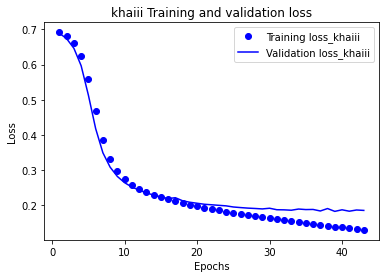

In [51]:
loss_khaiii= history_khaiii.history['loss']
val_loss_khaiii=history_khaiii.history['val_loss']

epochs = range(1, len(loss_khaiii) + 1)

plt.plot(epochs, loss_khaiii, 'bo',label="Training loss_khaiii" )
plt.plot(epochs, val_loss_khaiii, 'b', label='Validation loss_khaiii')
plt.title('khaiii Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

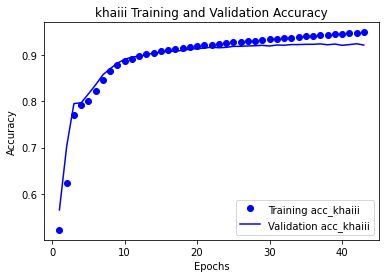

In [52]:
plt.clf() #그래프 초기화 

acc_khaiii = history_khaiii.history['accuracy']
val_acc_khaiii = history_khaiii.history['val_accuracy']

plt.plot(epochs, acc_khaiii, 'bo', label='Training acc_khaiii')
plt.plot(epochs, val_acc_khaiii, 'b', label='Validation acc_khaiii')

plt.title('khaiii Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [53]:
model_khaiii.save('model_khaiii.h5')

In [54]:
pred_khaiii_RNN=model_khaiii.predict(xTest_khaiii)

In [56]:
# xTest_khaiii=test_khaiii_ohe.values

In [57]:
pred_khaiii_RNN_list=[]
for i in range(len(pred_khaiii_RNN)):
    pred_khaiii_RNN_list.append(pred_khaiii_RNN[i].argmax())

In [58]:
test['pred_khaiii_RNN']=pred_khaiii_RNN_list
(test['label']==test['pred_khaiii_RNN']).sum()/test.shape[0]

0.9264970515766452

In [59]:
print(confusion_matrix(pred_khaiii_RNN_list, yTest))
print(classification_report(pred_khaiii_RNN_list, yTest))

[[17327  1432]
 [ 1223 16139]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     18759
           1       0.92      0.93      0.92     17362

    accuracy                           0.93     36121
   macro avg       0.93      0.93      0.93     36121
weighted avg       0.93      0.93      0.93     36121



# train_mecab_dtm, test_mecab_dtm

In [6]:
# train_mecab_dtm=pd.read_csv('train_mecab_dtm.csv')
# train_mecab_ohe=train_mecab_dtm.isnull()
# test_mecab_dtm=pd.read_csv('test_mecab_dtm.csv')
# test_mecab_ohe=test_mecab_dtm.isnull()

In [7]:
with open("data/train_mecab_dtm_array.pkl","rb") as fr:
    train_mecab_dtm_array=pickle.load(fr)
with open("data/test_mecab_dtm_array.pkl","rb") as fr:
    test_mecab_dtm_array=pickle.load(fr)

In [8]:
train_mecab_dtm=np.array(train_mecab_dtm_array)
train_mecab_ohe=np.where(train_mecab_dtm==0,0,1)
test_mecab_dtm=np.array(test_mecab_dtm_array)
test_mecab_ohe=np.where(test_mecab_dtm==0,0,1)

In [9]:
xTrain_mecab=train_mecab_ohe
xTest_mecab=test_mecab_ohe

In [ ]:
# xTrain_mecab=train_mecab_ohe.values
# xTest_mecab=test_mecab_ohe.values

# IF-IDF mecab

In [8]:
train_mecab_ifidf=tfidf(train_mecab_dtm)
test_mecab_ifidf=tfidf(test_mecab_dtm)

# naive_bayes_mecab

In [ ]:
model_mecab=CategoricalNB()
model_mecab.fit(xTrain_mecab, yTrain)

In [ ]:
pred_mecab_NB=model_mecab.predict(xTest_mecab)

In [ ]:
test['pred_mecab_NB']=pred_mecab_NB
print((test['label']==test['pred_mecab_NB']).sum()/test.shape[0])

In [ ]:
print(confusion_matrix(pred_mecab_NB, yTest))
print(classification_report(pred_mecab_NB, yTest))

# NB-SVM_mecab

In [9]:
def pr_mecab(y_i, y):
    p = train_mecab_dtm[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [11]:
def get_mdl_mecab(y):
    r = np.log(pr_mecab(1,y) / pr_mecab(0,y))
    m = LogisticRegression(C=0.1)
    x_nb = train_mecab_dtm*(r)
    return m.fit(x_nb, y), r

In [12]:
m,r = get_mdl_mecab(yTrain)
preds_mecab=m.predict_proba(test_mecab_dtm*(r))

In [13]:
pred_mecab_NB_SVM=[]
for i in preds_mecab:
    pred_mecab_NB_SVM.append(i.argmax())

test['pred_mecab_NB_SVM']=pred_mecab_NB_SVM
print((test['label']==test['pred_mecab_NB_SVM']).sum()/test.shape[0])

0.9388998089753883


In [14]:
print(confusion_matrix(pred_mecab_NB_SVM, yTest))
print(classification_report(pred_mecab_NB_SVM, yTest))

[[17141   798]
 [ 1409 16773]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     17939
           1       0.95      0.92      0.94     18182

    accuracy                           0.94     36121
   macro avg       0.94      0.94      0.94     36121
weighted avg       0.94      0.94      0.94     36121



# RNN_mecab

In [18]:
train['none']=train['label']==0
train['hate']=train['label']==1
yTrain=train[['none','hate']].values

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('model_mecab.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [20]:
model_mecab=Sequential()
model_mecab.add(Dense(2048,input_shape=(xTrain_mecab.shape[1],) ,activation='relu'))
model_mecab.add(Dense(512,activation='relu'))
model_mecab.add(Dense(64,activation='relu'))
model_mecab.add(Dense(8,activation='relu'))
model_mecab.add(Dense(2,activation='sigmoid'))

In [21]:
model_mecab.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [22]:
x_val_mecab = xTrain_mecab[:30000]
partial_x_train_mecab = xTrain_mecab[30000:]
y_val = yTrain[:30000]
partial_y_train = yTrain[30000:]

In [23]:
history_mecab = model_mecab.fit(partial_x_train_mecab,
                                partial_y_train,
                                epochs=300,
                                batch_size=512,
                                callbacks=[es, mc],
                                validation_data=(x_val_mecab, y_val))

Epoch 1/300
235/235 [==============================] - 21s 90ms/step - loss: 0.6913 - accuracy: 0.6064 - val_loss: 0.6891 - val_accuracy: 0.6972
Epoch 2/300
235/235 [==============================] - 21s 91ms/step - loss: 0.6858 - accuracy: 0.7399 - val_loss: 0.6817 - val_accuracy: 0.7677
Epoch 3/300
235/235 [==============================] - 21s 90ms/step - loss: 0.6756 - accuracy: 0.7784 - val_loss: 0.6685 - val_accuracy: 0.7773
Epoch 4/300
235/235 [==============================] - 22s 92ms/step - loss: 0.6577 - accuracy: 0.7742 - val_loss: 0.6448 - val_accuracy: 0.7772
Epoch 5/300
235/235 [==============================] - 22s 92ms/step - loss: 0.6251 - accuracy: 0.7840 - val_loss: 0.6019 - val_accuracy: 0.7907
Epoch 6/300
235/235 [==============================] - 22s 92ms/step - loss: 0.5675 - accuracy: 0.8102 - val_loss: 0.5275 - val_accuracy: 0.8308
Epoch 7/300
235/235 [==============================] - 22s 95ms/step - loss: 0.4762 - accuracy: 0.8476 - val_loss: 0.4205 - val_ac

235/235 [==============================] - 23s 97ms/step - loss: 0.1410 - accuracy: 0.9450 - val_loss: 0.1623 - val_accuracy: 0.9353
Epoch 28/300
235/235 [==============================] - 23s 97ms/step - loss: 0.1380 - accuracy: 0.9470 - val_loss: 0.1629 - val_accuracy: 0.9356
Epoch 29/300
235/235 [==============================] - 23s 97ms/step - loss: 0.1354 - accuracy: 0.9476 - val_loss: 0.1603 - val_accuracy: 0.9363
Epoch 30/300
235/235 [==============================] - 23s 97ms/step - loss: 0.1327 - accuracy: 0.9491 - val_loss: 0.1597 - val_accuracy: 0.9362
Epoch 31/300
235/235 [==============================] - 23s 97ms/step - loss: 0.1300 - accuracy: 0.9505 - val_loss: 0.1587 - val_accuracy: 0.9367
Epoch 32/300
235/235 [==============================] - 23s 97ms/step - loss: 0.1274 - accuracy: 0.9515 - val_loss: 0.1587 - val_accuracy: 0.9360
Epoch 33/300
235/235 [==============================] - 23s 97ms/step - loss: 0.1251 - accuracy: 0.9528 - val_loss: 0.1589 - val_accuracy

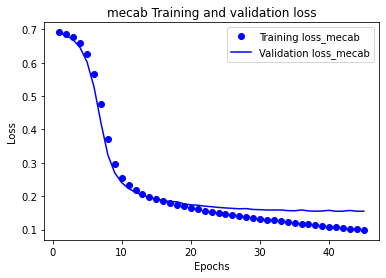

In [24]:
loss_mecab= history_mecab.history['loss']
val_loss_mecab=history_mecab.history['val_loss']

epochs = range(1, len(loss_mecab) + 1)

plt.plot(epochs, loss_mecab, 'bo',label="Training loss_mecab" )
plt.plot(epochs, val_loss_mecab, 'b', label='Validation loss_mecab')
plt.title('mecab Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

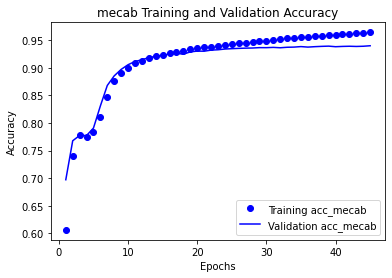

In [25]:
acc_mecab = history_mecab.history['accuracy']
val_acc_mecab = history_mecab.history['val_accuracy']

plt.plot(epochs, acc_mecab, 'bo', label='Training acc_mecab')
plt.plot(epochs, val_acc_mecab, 'b', label='Validation acc_mecab')

plt.title('mecab Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [26]:
model_mecab.save('model_mecab.h5')

In [27]:
pred_mecab_RNN=model_mecab.predict(xTest_mecab)

In [29]:
# xTest_mecab=test_mecab_ohe.values

In [30]:
pred_mecab_RNN_list=[]
for i in range(len(pred_mecab_RNN)):
    pred_mecab_RNN_list.append(pred_mecab_RNN[i].argmax())

In [31]:
test['pred_mecab_RNN']=pred_mecab_RNN_list
(test['label']==test['pred_mecab_RNN']).sum()/test.shape[0]

0.9395919271338002

In [34]:
print(confusion_matrix(pred_mecab_RNN_list, yTest))
print(classification_report(pred_mecab_RNN_list, yTest))

[[17311   943]
 [ 1239 16628]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18254
           1       0.95      0.93      0.94     17867

    accuracy                           0.94     36121
   macro avg       0.94      0.94      0.94     36121
weighted avg       0.94      0.94      0.94     36121



# train_okt_dtm, test_okt_dtm

In [10]:
# train_okt_dtm=pd.read_csv('train_okt_dtm.csv')
# train_okt_ohe=train_okt_dtm.isnull()
# test_okt_dtm=pd.read_csv('test_okt_dtm.csv')
# test_okt_ohe=test_okt_dtm.isnull()

In [35]:
with open("data/train_okt_dtm_array.pkl","rb") as fr:
    train_okt_dtm_array=pickle.load(fr)
with open("data/test_okt_dtm_array.pkl","rb") as fr:
    test_okt_dtm_array=pickle.load(fr)

In [36]:
train_okt_dtm=np.array(train_okt_dtm_array)
train_okt_ohe=np.where(train_okt_dtm==0,0,1)
test_okt_dtm=np.array(test_okt_dtm_array)
test_okt_ohe=np.where(test_okt_dtm==0,0,1)

In [37]:
xTrain_okt=train_okt_ohe
xTest_okt=test_okt_ohe

In [ ]:
# xTrain_okt=train_okt_ohe.values
# xTest_okt=test_okt_ohe.values

# IF-IDF okt

In [8]:
train_okt_ifidf=tfidf(train_okt_dtm)
test_okt_ifidf=tfidf(test_okt_dtm)

# naive_bayes_okt

In [ ]:
model_okt=CategoricalNB()
model_okt.fit(xTrain_okt, yTrain)

In [ ]:
pred_okt_NB=model_okt.predict(xTest_okt)

In [ ]:
test['pred_okt_NB']=pred_okt_NB
print((test['label']==test['pred_okt_NB']).sum()/test.shape[0])

In [ ]:
print(confusion_matrix(pred_okt_NB, yTest))
print(classification_report(pred_okt_NB, yTest))

# NB-SVM_okt

In [10]:
def pr_okt(y_i, y):
    p = train_okt_dtm[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [11]:
def get_mdl_okt(y):
    r = np.log(pr_okt(1,y) / pr_okt(0,y))
    m = LogisticRegression(C=0.1)
    x_nb = train_okt_dtm*(r)
    return m.fit(x_nb, y), r

In [12]:
m,r = get_mdl_okt(yTrain)
preds_okt=m.predict_proba(test_okt_dtm*(r))

In [13]:
pred_okt_NB_SVM=[]
for i in preds_okt:
    pred_okt_NB_SVM.append(i.argmax())

test['pred_okt_NB_SVM']=pred_okt_NB_SVM
print((test['label']==test['pred_okt_NB_SVM']).sum()/test.shape[0])

0.932310844107306


In [14]:
print(confusion_matrix(pred_okt_NB_SVM, yTest))
print(classification_report(pred_okt_NB_SVM, yTest))

[[17011   906]
 [ 1539 16665]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     17917
           1       0.95      0.92      0.93     18204

    accuracy                           0.93     36121
   macro avg       0.93      0.93      0.93     36121
weighted avg       0.93      0.93      0.93     36121



# RNN_okt

In [38]:
train['none']=train['label']==0
train['hate']=train['label']==1
yTrain=train[['none','hate']].values

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('model_okt.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [40]:
model_okt=Sequential()
model_okt.add(Dense(2048,input_shape=(xTrain_okt.shape[1],) ,activation='relu'))
model_okt.add(Dense(512,activation='relu'))
model_okt.add(Dense(64,activation='relu'))
model_okt.add(Dense(8,activation='relu'))
model_okt.add(Dense(2,activation='sigmoid'))

In [41]:
model_okt.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [42]:
x_val_okt = xTrain_okt[:30000]
partial_x_train_okt = xTrain_okt[30000:]
y_val = yTrain[:30000]
partial_y_train = yTrain[30000:]

In [44]:
history_okt = model_okt.fit(partial_x_train_okt,
                            partial_y_train,
                            epochs=300,
                            batch_size=512,
                            callbacks=[es, mc],
                            validation_data=(x_val_okt, y_val))

Epoch 1/300
235/235 [==============================] - 22s 93ms/step - loss: 0.6921 - accuracy: 0.5546 - val_loss: 0.6905 - val_accuracy: 0.6249
Epoch 2/300
235/235 [==============================] - 21s 90ms/step - loss: 0.6884 - accuracy: 0.6703 - val_loss: 0.6857 - val_accuracy: 0.7439
Epoch 3/300
235/235 [==============================] - 22s 92ms/step - loss: 0.6821 - accuracy: 0.7652 - val_loss: 0.6778 - val_accuracy: 0.7774
Epoch 4/300
235/235 [==============================] - 22s 95ms/step - loss: 0.6719 - accuracy: 0.7675 - val_loss: 0.6652 - val_accuracy: 0.7581
Epoch 5/300
235/235 [==============================] - 22s 96ms/step - loss: 0.6558 - accuracy: 0.7578 - val_loss: 0.6450 - val_accuracy: 0.7585
Epoch 6/300
235/235 [==============================] - 22s 96ms/step - loss: 0.6293 - accuracy: 0.7628 - val_loss: 0.6115 - val_accuracy: 0.7699
Epoch 7/300
235/235 [==============================] - 22s 95ms/step - loss: 0.5855 - accuracy: 0.7815 - val_loss: 0.5561 - val_ac

Epoch 28/300
235/235 [==============================] - 22s 95ms/step - loss: 0.1554 - accuracy: 0.9394 - val_loss: 0.1802 - val_accuracy: 0.9277
Epoch 29/300
235/235 [==============================] - 23s 96ms/step - loss: 0.1523 - accuracy: 0.9407 - val_loss: 0.1787 - val_accuracy: 0.9282
Epoch 30/300
235/235 [==============================] - 23s 96ms/step - loss: 0.1493 - accuracy: 0.9424 - val_loss: 0.1794 - val_accuracy: 0.9269
Epoch 31/300
235/235 [==============================] - 23s 96ms/step - loss: 0.1465 - accuracy: 0.9434 - val_loss: 0.1780 - val_accuracy: 0.9276
Epoch 32/300
235/235 [==============================] - 23s 96ms/step - loss: 0.1438 - accuracy: 0.9446 - val_loss: 0.1768 - val_accuracy: 0.9291
Epoch 33/300
235/235 [==============================] - 23s 96ms/step - loss: 0.1411 - accuracy: 0.9458 - val_loss: 0.1749 - val_accuracy: 0.9296
Epoch 34/300
235/235 [==============================] - 23s 96ms/step - loss: 0.1384 - accuracy: 0.9472 - val_loss: 0.1764 -

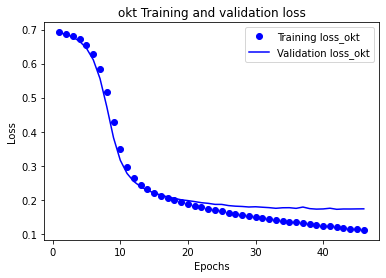

In [45]:
loss_okt= history_okt.history['loss']
val_loss_okt=history_okt.history['val_loss']

epochs = range(1, len(loss_okt) + 1)

plt.plot(epochs, loss_okt, 'bo',label="Training loss_okt" )
plt.plot(epochs, val_loss_okt, 'b', label='Validation loss_okt')
plt.title('okt Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

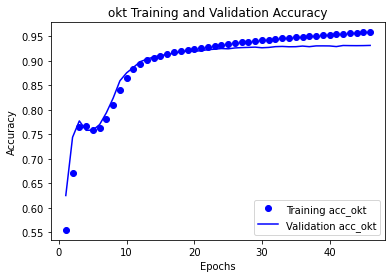

In [46]:
acc_okt = history_okt.history['accuracy']
val_acc_okt = history_okt.history['val_accuracy']

plt.plot(epochs, acc_okt, 'bo', label='Training acc_okt')
plt.plot(epochs, val_acc_okt, 'b', label='Validation acc_okt')

plt.title('okt Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [47]:
model_okt.save('model_okt.h5')

In [48]:
pred_okt_RNN=model_okt.predict(xTest_okt)

In [49]:
# xTest_okt=test_okt_ohe.values

In [50]:
pred_okt_RNN_list=[]
for i in range(len(pred_okt_RNN)):
    pred_okt_RNN_list.append(pred_okt_RNN[i].argmax())

In [51]:
test['red_okt_RNN']=pred_okt_RNN_list
(test['label']==test['red_okt_RNN']).sum()/test.shape[0]

0.9335012873397747

In [52]:
print(confusion_matrix(pred_okt_RNN_list, yTest))
print(classification_report(pred_okt_RNN_list, yTest))

[[17143   995]
 [ 1407 16576]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     18138
           1       0.94      0.92      0.93     17983

    accuracy                           0.93     36121
   macro avg       0.93      0.93      0.93     36121
weighted avg       0.93      0.93      0.93     36121

